In [1]:
import sys
import sqlite3

import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit, train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
sys.path.append('/home/pooya/w/DroughtMonitoringIran/')

DATABASE_PATH = "./database/database.db"

conn = sqlite3.connect(DATABASE_PATH)

data = pd.read_sql(sql='SELECT * FROM data', con=conn)

conn.close()

In [3]:
di = 'SPI'
di_scale = 9

selected_columns = [
    'Station_Name', 'Station_ID',
    'Station_Latitude', 'Station_Longitude', 'Station_Elevation',
    'Date',
    f'{di}_{di_scale}',
    'ERA5_Precipitation',
    'GPM_Precipitation',
    'TRMM_Precipitation',
    'TERRACLIMATE_Precipitation',
    'PERSIANNCDR_Precipitation',
    f'GPM_{di}_{di_scale}',
    f'ERA5_{di}_{di_scale}',
    'PET_MOD16A2GF',
    'NDVI', 'EVI',
    'LSTDay', 'LSTNight', 'LST',
    'PCI_GPM', 'VCI', 'TCI', 'VHI', 'CI_GPM',
]

In [4]:
df = data.filter(items=selected_columns)
df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m')
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Station_ID'] = df['Station_ID'].astype('category')
df['Year'] = df['Year'].astype('category')
df['Month'] = df['Month'].astype('category')

In [5]:
# selected_stations = ['Ramsar', 'Nowshahr']
# selected_stations = ['Siahbisheh', 'Kiyasar', 'Kojur', 'Baladeh', 'Alasht']
selected_stations = ['Babolsar', 'Gharakhil', 'Sari', 'Sari (dasht-e-naz airport)', 'Galugah', 'Bandar-e-amirabad', 'Amol', 'Polsefid']

start_date = '2006-09'
end_date = '2023-10'

df = df.query("Station_Name in @selected_stations and Date >= @start_date and Date < @end_date")

In [6]:
df.dropna(inplace=True)
df.sort_values(by=['Station_ID', 'Year', 'Month'], inplace=True)
df.reset_index(drop=True, inplace=True)

In [7]:
df[f'{di}_{di_scale}_Class'] = pd.cut(df[f'{di}_{di_scale}'], bins=[-10, -2, -1.5, -1, 1, 1.5, 2, 10], labels=['ED', 'SD', 'MD', 'NN', 'MW', 'VW', 'EW'])
df[f'{di}_{di_scale}_Class'] = df[f'{di}_{di_scale}_Class'].astype('category')

In [8]:
cols_to_lag = [
    'ERA5_Precipitation',
    'GPM_Precipitation',
    'TRMM_Precipitation',
    'TERRACLIMATE_Precipitation',
    'PERSIANNCDR_Precipitation',
    f'GPM_{di}_{di_scale}',
    f'ERA5_{di}_{di_scale}',
    'PET_MOD16A2GF',
    'NDVI', 'EVI',
    'LSTDay', 'LSTNight', 'LST',
    'PCI_GPM', 'VCI', 'TCI', 'VHI', 'CI_GPM'
]

for lag in range(1, 4):
    for col in cols_to_lag:
        df[f'{col}_lag_{lag}'] = df.groupby('Station_ID', observed=False)[col].shift(lag)

In [9]:
for col in cols_to_lag:
    df[f'{col}_roll_mean_3'] = df.groupby('Station_ID', observed=False)[col].transform(lambda x: x.rolling(window=3, min_periods=1).mean())
    df[f'{col}_roll_std_3'] = df.groupby('Station_ID', observed=False)[col].transform(lambda x: x.rolling(window=3, min_periods=1).std())
    df[f'{col}_roll_mean_6'] = df.groupby('Station_ID', observed=False)[col].transform(lambda x: x.rolling(window=6, min_periods=1).mean())
    df[f'{col}_roll_std_6'] = df.groupby('Station_ID', observed=False)[col].transform(lambda x: x.rolling(window=6, min_periods=1).std())
    df[f'{col}_roll_mean_9'] = df.groupby('Station_ID', observed=False)[col].transform(lambda x: x.rolling(window=9, min_periods=1).mean())
    df[f'{col}_roll_std_9'] = df.groupby('Station_ID', observed=False)[col].transform(lambda x: x.rolling(window=9, min_periods=1).std())
    df[f'{col}_roll_mean_12'] = df.groupby('Station_ID', observed=False)[col].transform(lambda x: x.rolling(window=12, min_periods=1).mean())
    df[f'{col}_roll_std_12'] = df.groupby('Station_ID', observed=False)[col].transform(lambda x: x.rolling(window=12, min_periods=1).std())


/tmp/ipykernel_51359/1487553917.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{col}_roll_std_6'] = df.groupby('Station_ID', observed=False)[col].transform(lambda x: x.rolling(window=6, min_periods=1).std())
/tmp/ipykernel_51359/1487553917.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{col}_roll_mean_9'] = df.groupby('Station_ID', observed=False)[col].transform(lambda x: x.rolling(window=9, min_periods=1).mean())
/tmp/ipykernel_51359/1487553917.py:7: PerformanceWarning: DataFrame is highly fragmented.  This 

In [10]:
df['Month'] = df['Month'].astype('int')
df['month_sin'] = np.sin(2 * np.pi * df['Month']/12.0)
df['month_cos'] = np.cos(2 * np.pi * df['Month']/12.0)
df['Month'] = df['Month'].astype('category')

/tmp/ipykernel_51359/121404930.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['month_sin'] = np.sin(2 * np.pi * df['Month']/12.0)
/tmp/ipykernel_51359/121404930.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['month_cos'] = np.cos(2 * np.pi * df['Month']/12.0)


In [11]:
df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)

X = df.drop(
    columns=[
        'Station_Name',
        'Station_ID',
        'Date',
        'Year',
        f'{di}_{di_scale}',
        f'{di}_{di_scale}_Class',
    ]
)

y = df[f'{di}_{di_scale}']

# Stacking Meta-Model

2025-08-19 20:22:48.973122: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-08-19 20:22:49.006126: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-08-19 20:22:49.105464: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1755622369.218296   51359 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1755622369.236861   51359 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1755622369.282725   51359 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linkin


--- Scaling Data ---

--- Performing Automatic Feature Selection with RFECV ---
Optimal number of features found by RFECV: 85
Capping features to 8.

--- Training Base Models to Create Meta-Features ---
Training rf...
Training cat...
Training xgb...
Training svr...
Training knn...
Meta-features created. Train shape: (953, 5), Test shape: (239, 5)

--- Building and Training the Neural Network Meta-Model for Regression ---


/home/pooya/w/DroughtMonitoringIran/.venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-08-19 21:04:17.282287: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 32)             │           192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 737 (2.88 KB)

 Trainable params: 737 (2.88 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/150
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - loss: 1.5107 - mae: 0.7361 - val_loss: 1.0462 - val_mae: 0.6006
Epoch 2/150
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 1.1107 - mae: 0.6021 - val_loss: 0.7119 - val_mae: 0.4462
Epoch 3/150
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.8878 - mae: 0.5232 - val_loss: 0.5650 - val_mae: 0.3703
Epoch 4/150
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.8727 - mae: 0.4868 - val_loss: 0.4996 - val_mae: 0.3343
Epoch 5/150
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.9720 - mae: 0.4948 - val_loss: 0.4590 - val_mae: 0.3138
Epoch 6/150
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.6580 - mae: 0.4287 - val_loss: 0.4147 - val_mae: 0.2916
Epoch 7/150
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 85ms/step - loss: 0.8352 - mae: 0.4501 - val_loss: 0.3882 - val_mae: 0.2771
Epoch 8/150
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.6157 - mae: 0.4089 - val_loss: 0.3757 - val_mae: 0.2749
Epoch 9/150
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - lo

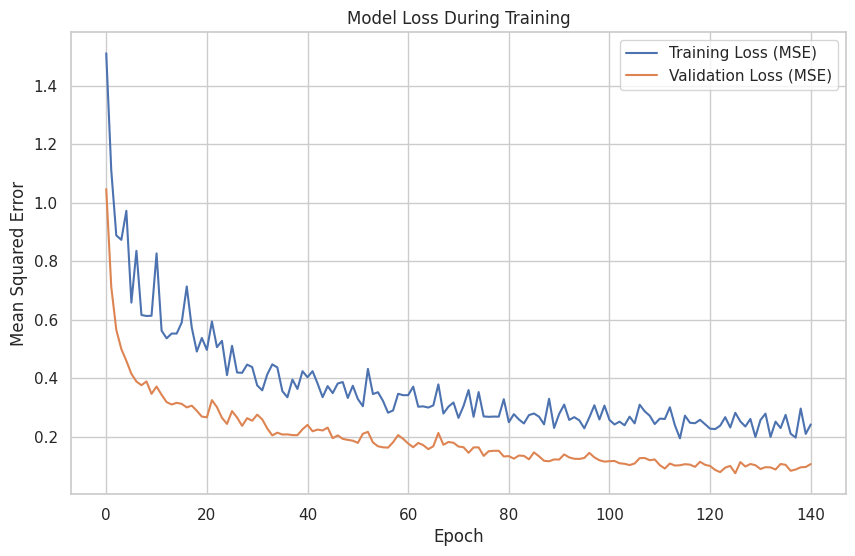

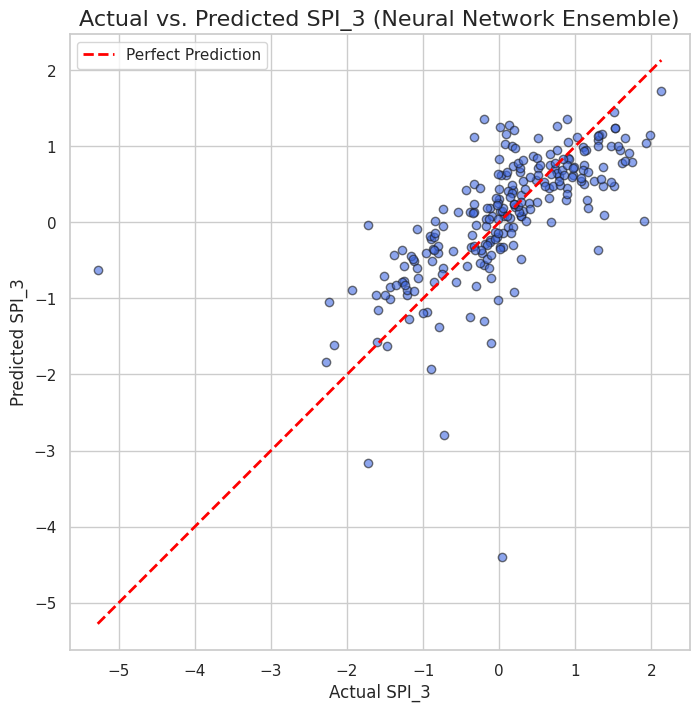

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# کتابخانه های مورد نیاز برای مدل های رگرسیون
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.feature_selection import RFECV, RFE

# کتابخانه های مورد نیاز برای شبکه عصبی
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2

# برای اطمینان از تکرارپذیری نتایج
tf.random.set_seed(100)
np.random.seed(100)



# --- 2. Comprehensive Feature Engineering ---
# ستون کلاس از لیست حذف شد
features_to_exclude = ['SPI_3', 'SPI_3_Class', 'Station_ID'] 


# --- 3. Data Splitting, Scaling, and Feature Selection ---
# Stratify دیگر برای رگرسیون استفاده نمی شود
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42
)

# استانداردسازی داده ها
print("\n--- Scaling Data ---")
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# انتخاب خودکار بهترین تعداد ویژگی با RFECV برای رگرسیون
print("\n--- Performing Automatic Feature Selection with RFECV ---")
estimator = RandomForestRegressor(n_estimators=50, random_state=42, n_jobs=-1)
max_features_cap = 8

# معیار ارزیابی به معیار رگرسیون تغییر یافت
selector_cv = RFECV(estimator, step=1, cv=KFold(3), scoring='neg_mean_squared_error', min_features_to_select=3, n_jobs=-1)
selector_cv = selector_cv.fit(X_train_scaled, y_train)

optimal_n_features = selector_cv.n_features_
print(f"Optimal number of features found by RFECV: {optimal_n_features}")

if optimal_n_features > max_features_cap:
    print(f"Capping features to {max_features_cap}.")
    selector = RFE(estimator, n_features_to_select=max_features_cap, step=1)
    selector = selector.fit(X_train_scaled, y_train)
else:
    selector = selector_cv

X_train_selected = selector.transform(X_train_scaled)
X_test_selected = selector.transform(X_test_scaled)

# --- 4. Train Base Models and Create Meta-Features ---
print("\n--- Training Base Models to Create Meta-Features ---")

# تعریف مدل های پایه رگرسیون
base_models = {
    'rf': RandomForestRegressor(n_estimators=400, min_samples_split=5, max_depth=20, random_state=42, n_jobs=-1),
    'cat': CatBoostRegressor(learning_rate=0.1, iterations=500, depth=6, random_state=42, verbose=0),
    'xgb': XGBRegressor(n_estimators=200, max_depth=7, learning_rate=0.1, random_state=42, n_jobs=-1),
    'svr': SVR(gamma='scale', C=10),
    'knn': KNeighborsRegressor(n_neighbors=5, n_jobs=-1)
}

# آموزش مدل های پایه و گرفتن پیش بینی های آنها به عنوان ویژگی های جدید
meta_X_train_list = []
meta_X_test_list = []

for name, model in base_models.items():
    print(f"Training {name}...")
    model.fit(X_train_selected, y_train)
    # گرفتن پیش بینی های عددی به عنوان ویژگی
    train_preds = model.predict(X_train_selected)
    test_preds = model.predict(X_test_selected)
    meta_X_train_list.append(train_preds.reshape(-1, 1))
    meta_X_test_list.append(test_preds.reshape(-1, 1))

# ترکیب پیش بینی ها برای ساخت دیتاست متا
meta_X_train = np.concatenate(meta_X_train_list, axis=1)
meta_X_test = np.concatenate(meta_X_test_list, axis=1)
print(f"Meta-features created. Train shape: {meta_X_train.shape}, Test shape: {meta_X_test.shape}")


# --- 5. Build, Compile, and Train the Neural Network Meta-Model ---
print("\n--- Building and Training the Neural Network Meta-Model for Regression ---")

# ساخت مدل Sequential برای رگرسیون
nn_model = Sequential()
nn_model.add(Dense(32, input_dim=meta_X_train.shape[1], activation='relu', kernel_regularizer=l2(0.01)))
nn_model.add(Dropout(0.5))
nn_model.add(Dense(16, activation='relu', kernel_regularizer=l2(0.01)))
nn_model.add(Dropout(0.5))
# لایه خروجی برای رگرسیون: یک نورون با تابع فعال سازی خطی
nn_model.add(Dense(1, activation='linear'))

# کامپایل کردن مدل با تابع هزینه و معیارهای رگرسیون
nn_model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
nn_model.summary()

# آموزش مدل
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
history = nn_model.fit(
    meta_X_train,
    y_train,
    epochs=150,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping],
    verbose=1
)

# --- 6. Prediction and Evaluation ---
print("\n--- Evaluating the Final Neural Network Model ---")
y_pred = nn_model.predict(meta_X_test).flatten()

# استفاده از معیارهای ارزیابی رگرسیون
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)

print("\n--- Final Model Evaluation Metrics (Neural Network Ensemble Regressor) ---")
print(f"R-squared (R²): {r2:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")

# --- 7. Visualization ---
sns.set_theme(style="whitegrid")

# الف) نمودار خطا در طول آموزش
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss (MSE)')
plt.plot(history.history['val_loss'], label='Validation Loss (MSE)')
plt.title('Model Loss During Training')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.show()

# ب) نمودار مقادیر واقعی در برابر پیش بینی شده
plt.figure(figsize=(8, 8))
plt.scatter(y_test, y_pred, alpha=0.6, edgecolors='k', c='royalblue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--', color='red', lw=2, label='Perfect Prediction')
plt.title('Actual vs. Predicted SPI_3 (Neural Network Ensemble)', fontsize=16)
plt.xlabel('Actual SPI_3', fontsize=12)
plt.ylabel('Predicted SPI_3', fontsize=12)
plt.legend()
plt.grid(True)
plt.axis('equal')
plt.show()